In [1]:
# Install required library

!pip install sentence_transformers -q

In [2]:
import re
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

In [3]:
null = None

In [4]:
# Job description for matching
job_description = """Looking for a candidate with expertise in Python, Machine Learning, NLP, and SQL. 
Must have experience in building predictive models and working with large datasets."""

In [5]:
  resumes = [{"Name": 'Steve SunA', 'Email': 'stevesun1245@gmail.com', 'Skills': ['Python', 'Data Analysis', 'Machine Learning', 'Communication', 'Deep Learning', 'SQL', 'AI', 'Data Visualization', 'Statistical Analysis', 'Big Data', 'Critical Thinking', 'Storytelling'], 'Education': {'University': ['EDUCATION\nSkyline University'], 'Degree': ['Master of Science in Data Science'], 'GPA': ['3.81 GPA'], 'Start Date': ['August 2018'], 'End Date': ['May 2020']}, 'Experience': {'work': ['DataNova Insights\nData Scientist March 2021 – Present\n• Developed and deployed machine learning models to optimize customer retention, increasing\nengagement by 15%.\n• Conducted exploratory data analysis (EDA) and statistical testing to derive actionable business\ninsights.\n• Built scalable ETL pipelines to process large datasets using Python and SQL.\n• Collaborated with cross-functional teams to improve decision-making through predictive analytics.\nNeural Sphere Labs\nData Scientist June 2019 – December 2023\n• Designed and implemented deep learning models for image classification, improving accuracy by\n20%.\n• Automated data preprocessing and feature engineering workflows using Python and Pandas.\n• Created interactive dashboards in Power BI to visualize key performance indicators (KPIs).\n• Partnered with engineers to deploy ML models into production, ensuring seamless integration.']}}
    
    ,
{
  "Contact Information": {
    "Name": "Steve Sun",
    "Email": "stevesun1245@gmail.com",
    "Phone Number": "(123)456789",
    "Website/Portfolio/LinkedIn": "linkedin.com/in/stevesun",
    "Github Profile": null
  },
  "Education": [
    {
      "Institution Name": "Skyline University",
      "Degree": "Master of Science in Data Science",
      "Graduation Date": "May 2020",
      "GPA": "3.81"
    }
  ],
  "Experience": [
    {
      "Job Title": "Data Scientist",
      "Company Name": "DataNova Insights",
      "Location": "Hyderabad",
      "Dates of Employment": "March 2021 - Present",
      "Description": "Developed and deployed machine learning models to optimize customer retention, increasing engagement by 15%. Conducted exploratory data analysis (EDA) and statistical testing to derive actionable business insights. Built scalable ETL pipelines to process large datasets using Python and SQL. Collaborated with cross-functional teams to improve decision-making through predictive analytics."
    },
    {
      "Job Title": "Data Scientist",
      "Company Name": "Neural Sphere Labs",
      "Location": null,
      "Dates of Employment": "June 2019 - December 2023",
      "Description": "Designed and implemented deep learning models for image classification, improving accuracy by 20%. Automated data preprocessing and feature engineering workflows using Python and Pandas. Created interactive dashboards in Power BI to visualize key performance indicators (KPIs). Partnered with engineers to deploy ML models into production, ensuring seamless integration."
    }
  ],
  "Skills": [
    "Python",
    "SQL",
    "Machine Learning",
    "AI",
    "Data Visualization",
    "Statistical Analysis",
    "Big Data",
    "Cloud Technologies",
    "Problem-Solving",
    "Critical Thinking",
    "Communication",
    "Storytelling"
  ]
}
           ]

In [6]:
# Function Definitions

def normalize_text(data):
    """
    Recursively extract and combine text from nested dictionaries and lists.
    """
    if isinstance(data, str):
        return data
    elif isinstance(data, list):
        return " ".join(normalize_text(item) for item in data)
    elif isinstance(data, dict):
        return " ".join(normalize_text(value) for value in data.values())
    else:
        return str(data)

def match_resume_to_job(resume_text, job_description, model):
    """
    Compute similarity between resume text and job description using a sentence-transformer model.
    """
    embeddings = model.encode([resume_text, job_description], convert_to_tensor=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1])
    return similarity.item()

def compute_skill_match(skills, job_description):
    """
    Compute the percentage of skills that match the job description.
    """
    matched_skills = [skill for skill in skills if skill.lower() in job_description.lower()]
    return len(matched_skills) / len(skills) if skills else 0

In [13]:
def rank_candidates(resumes, job_description, model):
    """
    Rank candidates based on similarity scores for skills, education, and experience.
    """
    scores = []

    for resume in resumes:
        skills_text = normalize_text(resume.get("Skills", []))
        print(skills_text)
        experience_text = normalize_text(resume.get("Experience", {}))
        print(experience_text)
        education_text = normalize_text(resume.get("Education", {}))


        # Compute similarity scores
        skill_score = match_resume_to_job(skills_text, job_description, model)
        print(skill_score)
        experience_score = match_resume_to_job(experience_text, job_description, model)
        education_score = match_resume_to_job(education_text, job_description, model)
        keyword_match_score = compute_skill_match(resume.get("Skills", []), job_description)

        # Weighted total score
        total_score = 0.5 * skill_score + 0.4 * experience_score + 0.1 * education_score + 0.1 * keyword_match_score

        # Collect scores
        scores.append({
            "Name": resume.get("Name") or resume["Contact Information"]["Name"],
            "Skill Score": skill_score,
            "Experience Score": experience_score,
            "Education Score": education_score,
            "Keyword Match Score": keyword_match_score,
            "Total Score": total_score
        })

    return sorted(scores, key=lambda x: x["Total Score"], reverse=True)

In [14]:

def plot_scores(ranked_candidates):
    """
    Visualize the scores of candidates using a bar chart.
    """
    names = [candidate['Name'] for candidate in ranked_candidates]
    skill_scores = [candidate['Skill Score'] for candidate in ranked_candidates]
    experience_scores = [candidate['Experience Score'] for candidate in ranked_candidates]
    education_scores = [candidate['Education Score'] for candidate in ranked_candidates]
    keyword_match_scores = [candidate['Keyword Match Score'] for candidate in ranked_candidates]

    # Plot setup
    bar_width = 0.2
    index = range(len(names))

    # Create bars for each category
    plt.bar(index, skill_scores, bar_width, label="Skills")
    plt.bar([i + bar_width for i in index], experience_scores, bar_width, label="Experience")
    plt.bar([i + 2 * bar_width for i in index], education_scores, bar_width, label="Education")
    plt.bar([i + 3 * bar_width for i in index], keyword_match_scores, bar_width, label="Keyword Match")

    # Configure plot details
    plt.xticks([i + 1.5 * bar_width for i in index], names)
    plt.xlabel("Candidates")
    plt.ylabel("Scores")
    plt.title("Candidate Comparison")
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

In [8]:
# Load SentenceTransformer model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
# Rank candidates
ranked_candidates = rank_candidates(resumes, job_description, model)

Python Data Analysis Machine Learning Communication Deep Learning SQL AI Data Visualization Statistical Analysis Big Data Critical Thinking Storytelling
DataNova Insights
Data Scientist March 2021 – Present
• Developed and deployed machine learning models to optimize customer retention, increasing
engagement by 15%.
• Conducted exploratory data analysis (EDA) and statistical testing to derive actionable business
insights.
• Built scalable ETL pipelines to process large datasets using Python and SQL.
• Collaborated with cross-functional teams to improve decision-making through predictive analytics.
Neural Sphere Labs
Data Scientist June 2019 – December 2023
• Designed and implemented deep learning models for image classification, improving accuracy by
20%.
• Automated data preprocessing and feature engineering workflows using Python and Pandas.
• Created interactive dashboards in Power BI to visualize key performance indicators (KPIs).
• Partnered with engineers to deploy ML models into

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.5235879421234131


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Python SQL Machine Learning AI Data Visualization Statistical Analysis Big Data Cloud Technologies Problem-Solving Critical Thinking Communication Storytelling
Data Scientist DataNova Insights Hyderabad March 2021 - Present Developed and deployed machine learning models to optimize customer retention, increasing engagement by 15%. Conducted exploratory data analysis (EDA) and statistical testing to derive actionable business insights. Built scalable ETL pipelines to process large datasets using Python and SQL. Collaborated with cross-functional teams to improve decision-making through predictive analytics. Data Scientist Neural Sphere Labs None June 2019 - December 2023 Designed and implemented deep learning models for image classification, improving accuracy by 20%. Automated data preprocessing and feature engineering workflows using Python and Pandas. Created interactive dashboards in Power BI to visualize key performance indicators (KPIs). Partnered with engineers to deploy ML model

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.5074076652526855


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
# Display ranked candidates
for candidate in ranked_candidates:
    print(f"Name: {candidate['Name']}, Total Score: {candidate['Total Score']:.2f}")

Name: Steve SunA, Total Score: 0.57
Name: Steve Sun, Total Score: 0.52


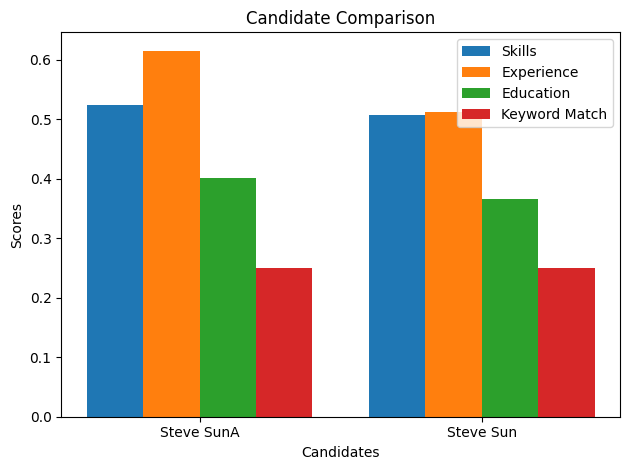

In [17]:
# Plot the scores
plot_scores(ranked_candidates)